(13, 303)
(1, 303)
(13, 203)
(1, 203)
第10轮训练损失为： 40.88, 测试损失为： 48.93
第20轮训练损失为： 40.87, 测试损失为： 48.95
第30轮训练损失为： 40.86, 测试损失为： 48.96
第40轮训练损失为： 40.85, 测试损失为： 48.98
第50轮训练损失为： 40.85, 测试损失为： 49.0
第60轮训练损失为： 40.84, 测试损失为： 49.02
第70轮训练损失为： 40.83, 测试损失为： 49.03
第80轮训练损失为： 40.82, 测试损失为： 49.05
第90轮训练损失为： 40.81, 测试损失为： 49.07
第100轮训练损失为： 40.81, 测试损失为： 49.09


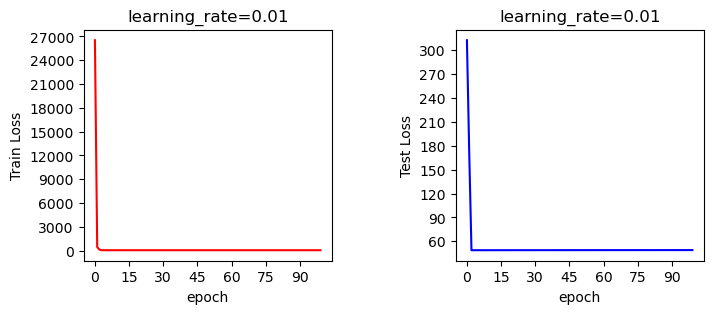

In [11]:
import math

from matplotlib import ticker
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

'''
    编写L层神经网络，预测图片是否为猫
'''

# 激活函数
def sigmod(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def softmax(Z):
    cache = Z
    Z -= np.max(Z, axis=0, keepdims=True)
    # Compute softmax
    e_Z = np.exp(Z)
    A = e_Z / np.sum(e_Z, axis=0, keepdims=True)
    return A, cache

# 随机初始化权重参数
def init_parameters(layers_dims):
    '''
    :param layers_dims: 网络中每层节点的数量列表
    :return:
    '''
    '''
        z_i = w_i * x_{i-1} + b_i
        第i层w的维度为：(n_i, n_{i-1})
        第i层b的维度为：(n_i, 1)
    '''
    params = {}
    for i in range(1, len(layers_dims)):
        params["W" + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1]) * np.sqrt(2 / (layers_dims[i-1]))
        params["b" + str(i)] = np.zeros((layers_dims[i], 1))

        assert (params["W" + str(i)].shape == (layers_dims[i], layers_dims[i-1]))
        assert (params["b" + str(i)].shape == (layers_dims[i], 1))
    return params

def init_zeros(layers_dims):
    parameters = {}
    # np.random.seed(3)
    for i in range(1, len(layers_dims)):
        parameters["W" + str(i)] = np.zeros((layers_dims[i], layers_dims[i-1]))
        parameters["b" + str(i)] = np.zeros((layers_dims[i], 1))

        assert (parameters["W" + str(i)].shape == (layers_dims[i], layers_dims[i - 1]))
        assert (parameters["b" + str(i)].shape == (layers_dims[i], 1))
    return parameters

def init_random(layers_dims):
    parameters = {}
    # np.random.seed(3)
    for i in range(1, len(layers_dims)):
        parameters["W" + str(i)] = np.random.randn(layers_dims[i], layers_dims[i - 1]) * 0.01
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))

        assert (parameters["W" + str(i)].shape == (layers_dims[i], layers_dims[i - 1]))
        assert (parameters["b" + str(i)].shape == (layers_dims[i], 1))
    return parameters
'''
 前向传播: 
    1. 计算预测值
    2. 计算激活函数值
'''
def linear_forward(A, W, b):
    '''
    :param A: 上一层的输出值
    :param W: 权重矩阵
    :param b: 偏向量
    :return:
    '''
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    assert (Z.shape == (W.shape[0], A.shape[1]))
    return (Z, cache)

def linear_activation_forward(A, W, b, activation):
    Z, linear_cache = linear_forward(A, W, b)
    activation_cache = []
    if activation == "sigmod":
        A, activation_cache = sigmod(Z)
    if activation == "relu":
        A, activation_cache = relu(Z)
    if activation == "softmax":
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    L = len(parameters) // 2
    A = X
    caches = []
    for i in range(1, L):
        prev_A = A # 上一层的输出值
        A, cache = linear_activation_forward(prev_A, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        # print(f"====================={i}====================")
        # print(A)
        caches.append(cache)
    # 输出层的输出值: AL
    AL, cache = linear_forward(A, parameters["W" + str(L)], parameters["b" + str(L)])
    caches.append(cache)
    assert (AL.shape == (1, X.shape[1]))
    return AL, caches

# 计算成本函数
def compute_cost(AL, y):
    m = AL.shape[1]
    # print(AL)
    # cost = - (np.sum(y * np.log(AL) + (1 - y) * np.log(1 - AL), axis=1)) / m
    # cost = - (np.sum(y * np.log(AL + 1e-8), axis=1)) / m
    cost = np.sum(np.power(AL - y, 2)) / (2 * m)
    return cost

'''
    反向传播：
        第一步：计算激活函数的梯度
        第二步：计算线性的梯度
'''
# sigmod 激活函数的梯度
def sigmod_backward(dA, cache):
    Z = cache
    a = 1 / (1 + np.exp(-Z))
    dZ = dA * a * (1 - a)
    assert (Z.shape == dZ.shape)
    return dZ

# relu 激活函数的梯度
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (Z.shape == dZ.shape)
    return dZ

def softmax_backward(dA, cache):
    Z = cache
    N = Z.shape[0]  # Assuming Z is a column vector
    dZ = np.zeros_like(Z)
    for i in range(N):
        for j in range(N):
            dZ[i] += dA[j] * Z[i] * (int(i == j) - Z[j])
    return dZ

# 线性部分的梯度
def linear_backward(dZ, cache):
    # A表示当前层的输入
    A, W, b = cache
    # 样本的个数
    m = A.shape[1]
    dW = np.dot(dZ, A.T) * (1 / m)
    db = np.sum(dZ, axis=1, keepdims=True) * (1 / m) # keepdims=True, 表示保持维度
    dA_prev = np.dot(W.T, dZ) # 表示前一层输出的梯度，也就是当前层的输入值的梯度
    return dA_prev, dW, db

# 整合一层的线性和激活函数的梯度
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "sigmod":
        # 先计算激活函数的梯度
        dZ = sigmod_backward(dA, activation_cache)
        # 计算线性部分的梯度
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    if activation == "softmax":
        # dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dA, linear_cache)

    return dA_prev, dW, db

# 整合反向传播的梯度下降过程
def L_model_backward(AL, y, caches):
    '''
    :param AL: 前向传播的输出值
    :param y: 输出标签值
    :param caches: 存储了前向传播过程中计算得到的线性部分和激活部分的相关值
    :return:
    '''
    grads = {} # 存储参数梯度值，用于更新每层的参数
    y = y.reshape(1, AL.shape[1])
    L = len(caches)

    dA = (AL - y)

    dA_prev, dW, db = linear_backward(dA, caches[L-1])
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db
    for i in reversed(range(L-1)):
        dA = grads["dA" + str(i+2)]
        dA_prev, dW, db = linear_activation_backward(dA, caches[i], "relu")
        grads["dA" + str(i+1)], grads["dW" + str(i+1)], grads["db" + str(i+1)] = dA_prev, dW, db

    return grads

# 更新每一层的参数
def update_parameters(parameters, grads, learning_rate):
    '''
    :param parameters: 参数
    :param grads: 梯度值
    :param learning_rate: 学习率
    :return:
    '''
    L = len(parameters) // 2
    for i in range(L):
        parameters["W" + str(i+1)] -= learning_rate * grads["dW" + str(i+1)]
        parameters["b" + str(i+1)] -= learning_rate * grads["db" + str(i+1)]
    return parameters

def eval_model(test_bacthes, parameters):
    costs = 0
    total_num = 0
    for X, Y in test_bacthes:
        total_num += Y.shape[1]
        costs += prediction(X, Y, parameters) * Y.shape[1]
    return costs / total_num

# 封装成一个L层神经网络
def L_layer_model(train_bathces, test_bacthes, layer_dims,learning_rate=0.0075, iteration_num=3000, print_cost=True, isPlot=True, initialization="he"):
    '''
    :param X: 输入特征
    :param Y:  输出标签
    :param layer_dims: 层数向量
    :param learning_rate: 学习率
    :param iteration_num: 迭代次数
    :param print_cost: 是否打印成本值
    :param isPlot: 是否绘制学习曲线
    :return: 返回学习到的模型参数
    '''
    # 1.初始化参数W和b
    if initialization == "zeros":
        parameters = init_zeros(layer_dims)
    elif initialization == "random":
        parameters = init_random(layer_dims)
    elif initialization == "he":
        parameters = init_parameters(layer_dims)
    else:
        print("请选择正确的初始化参数的方法！")
    test_accuracy_epoch = []
    train_loss_epoch, test_loss_epoch = [], []
    for i in range(iteration_num):
        total = 0
        cost = 0
        for X, Y in train_bathces:
            AL, caches = L_model_forward(X, parameters)  # 2.前向传播
            cost += compute_cost(AL, Y) * Y.shape[1]  # 3.计算成本值
            total += Y.shape[1]
            grads = L_model_backward(AL, Y, caches)  # 4.反向传播
            parameters = update_parameters(parameters, grads, learning_rate)  # 5.更新参数

        model_loss = eval_model(test_bacthes, parameters)
        test_accuracy_epoch.append(model_loss)
        train_loss_epoch.append(cost / total)
        test_loss_epoch.append(model_loss)
        if (i + 1) % 10 == 0:
            print(f"第{i + 1}轮训练损失为：{cost / total: .4}, 测试损失为：{model_loss: .4}")
    if isPlot:
        _, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].plot(range(len(train_loss_epoch)), train_loss_epoch, c='r') 
        axes[0].set_xlabel("epoch")
        axes[0].set_ylabel("Train Loss")
        axes[0].set_title("learning_rate={}".format(learning_rate))
        axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        axes[1].plot(range(len(test_loss_epoch)), test_loss_epoch, c='b')
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("Test Loss")
        axes[1].set_title("learning_rate={}".format(learning_rate))
        axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        plt.subplots_adjust(wspace=0.5)
        plt.show()
    return parameters

def prediction(X, Y, parameters):
    # 进行一次前向传播计算预测值
    AL, caches = L_model_forward(X, parameters)
    return compute_cost(AL, Y)

def f1_score(prediction_Y, Y):
    tp, fp, fn = 0, 0, 0
    for i in range(prediction_Y.shape[1]):
        if prediction_Y[0, i] == Y[0, i] and Y[0, i] == 1:
            tp += 1
        if prediction_Y[0, i] == 1 and Y[0, i] == 0:
            fp += 1
        if prediction_Y[0, i] == 0 and Y[0, i] == 1:
            fn += 1
    P = tp / (tp + fp) if tp + fp != 0 else 0
    R = tp / (tp + fn) if tp + fn != 0 else 0
    return 2*P*R / (P+R) if P+R != 0 else 0

def plot_decision_boundary(X, Y, parameters):
    minx1, maxx1 = X[0, :].min() - 0.3, X[0, :].max() + 0.3
    minx2, maxx2 = X[1, :].min() - 0.3, X[1, :].max() + 0.3
    x = np.linspace(minx1, maxx1, 100)
    y = np.linspace(minx2, maxx2, 100)
    meshX, meshY = np.meshgrid(x, y)
    edge_data = np.vstack((meshX.ravel(), meshY.ravel()))
    print(X.shape)
    print(edge_data.shape)
    meshZ = prediction(edge_data, parameters).reshape(meshX.shape)
    print(meshX.shape)
    plt.contourf(meshX, meshY, meshZ, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=Y, marker=".", cmap=plt.cm.Spectral)
    plt.contour(meshX, meshY, meshZ, cmap=plt.cm.Spectral)
    plt.show()


# 将批量的数据集划分成大小为mini_batch_size的小批次数据集
def random_mini_batches(X, Y, mini_batch_size=64, seed=3):
    # np.random.seed(seed)
    m = X.shape[1] # 样本的数量
    mini_batches = []

    # 1. 第一步：打乱顺序
    permuation = np.random.permutation(m) # 产生一个0~m-1的随机排列
    shuffled_X = X[:, permuation] # 以数组的形式取X中的数据
    shuffled_Y = Y[:, permuation]

    # 2. 第二步：分割数据集
    num_complete_minibatches = math.floor(m / mini_batch_size) # 批次数
    for k in range(num_complete_minibatches):
        mini_bacth_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_bacth_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batches.append((mini_bacth_X, mini_bacth_Y))

    # 3. 第三步：如果m不是mini_batch_size的整数倍，那么剩余的样本需要重新整合到一个mini-batch中
    if m % mini_batch_size != 0:
        mini_bacth_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : m]
        mini_bacth_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : m]
        mini_batches.append((mini_bacth_X, mini_bacth_Y))

    return mini_batches

def load_dataset():
    dataset = pd.read_csv("../dataset/boston/HousingData.csv")

    columns = list(dataset.columns)
    for i in range(len(columns) - 1):
        col_name = columns[i]
        dataset.fillna(dataset[col_name].mean(), inplace=True)


    X = dataset.values[:, :-1]
    Y = dataset.values[:, -1].reshape(506, -1)

    num = X.shape[0]

    train_X = X[:int(num * 0.6), :]
    test_X = X[int(num * 0.6):, :]
    train_Y = Y[:int(num * 0.6), :]
    test_Y = Y[int(num * 0.6):, :]

    return train_X, train_Y, test_X, test_Y

if __name__ == "__main__":

    np.random.seed(3) # 保证每次得到的都是相同的随机数

    train_X, train_Y, test_X, test_Y = load_dataset()

    # 将每个训练的特征压缩成一个大的一维特征向量
    train_X = train_X.T # (13, 506 * 0.6)
    test_X = test_X.T # (13, 506 - 506 * 0.6)

    train_Y = train_Y.reshape(1, -1)
    test_Y = test_Y.reshape(1, -1)

    print(train_X.shape)
    print(train_Y.shape)
    print(test_X.shape)
    print(test_Y.shape)

    # print(train_set_x)

    # 归一化特征向量
    # train_X = (train_X - np.mean(train_X, axis=0, keepdims=True) / np.nanstd(train_X, axis=0, keepdims=True))
    # test_X = (test_X - np.mean(test_X, axis=0, keepdims=True) / np.nanstd(test_X, axis=0, keepdims=True))
    train_X = (train_X - np.min(train_X, axis=0, keepdims=True) / (np.max(train_X, axis=0, keepdims=True) - np.min(train_X, axis=0, keepdims=True)))
    test_X = (test_X - np.min(test_X, axis=0, keepdims=True) / (np.max(test_X, axis=0, keepdims=True) - np.min(test_X, axis=0, keepdims=True)))

    # 批量化数据
    train_batches = random_mini_batches(train_X, train_Y, 16, 3)
    test_batches = random_mini_batches(test_X, test_Y, 16, 3)


    # 使用封装好的神经网络进行训练
    layer_dims = [13, 10, 5, 5, 1] # 构建一个五层的神经网络， 输入层的神经元个数是输入特征向量的个数
    parameters = L_layer_model(train_batches, test_batches, layer_dims, learning_rate=0.01, iteration_num=100, print_cost=True, isPlot=True, initialization="random")